In [6]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output
from skimage import img_as_ubyte

In [7]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

In [8]:
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

In [9]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

### Exercise 1
Load the ImgT1.nii image and visualize its three ortho-views in one plot being the axial, sagittal, and coronal views

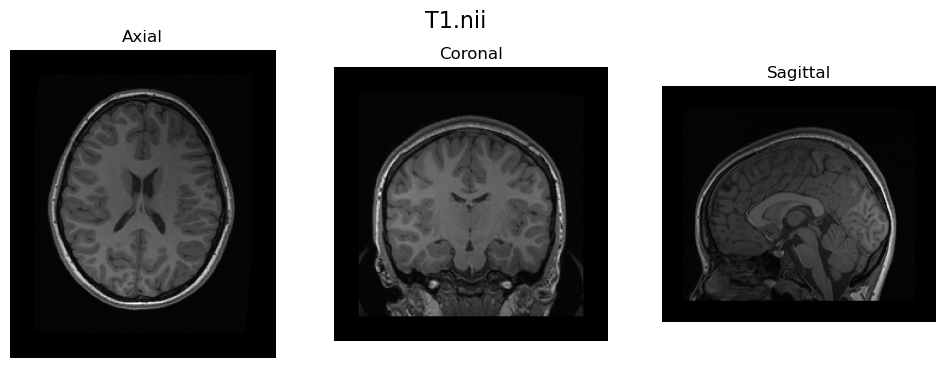

In [10]:
dir_in = 'data/'
vol_sitk = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Display the volume
imshow_orthogonal_view(vol_sitk, title='T1.nii')

### Exercise 2
Write a function rotation_matrix(pitch, roll, yaw) which returns the rotation matrix for a given a roll, pitch, yaw. Make a 4x4 affine matrix with a pitch of 25 degrees.

In [13]:
import numpy as np
from math import radians

def rotation_matrix(pitch, roll, yaw):
    # Rotation matrix around x-axis (pitch)
    Rx = np.array([[1, 0, 0, 0],
                   [0, np.cos(pitch), np.sin(pitch), 0],
                   [0, -np.sin(pitch), np.cos(pitch), 0],
                   [0, 0, 0, 1]])

    # Rotation matrix around y-axis (roll)
    Ry = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                   [0, 1, 0, 0],
                   [-np.sin(roll), 0, np.cos(roll), 0],
                   [0, 0, 0, 1]])

    # Rotation matrix around z-axis (yaw)
    Rz = np.array([[np.cos(yaw), np.sin(yaw), 0, 0],
                   [-np.sin(yaw), np.cos(yaw), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

    # Combine the rotation matrices
    rotation_matrix = Rz @ Ry @ Rx

    return rotation_matrix

# Example: Create a 4x4 affine matrix with a pitch of 25 degrees
pitch_angle = np.deg2rad(25)

affine_matrix = rotation_matrix(pitch_angle, 0, 0)
print(affine_matrix)


[[ 1.          0.          0.          0.        ]
 [ 0.          0.90630779  0.42261826  0.        ]
 [ 0.         -0.42261826  0.90630779  0.        ]
 [ 0.          0.          0.          1.        ]]


### Exercise 3
Apply the rotation to the ImgT1.nii around the central point of the volume and save the rotated images as ImgT1_A.nii. 

In [14]:
# Define the roll rotation in radians
angle = 25  # degrees
pitch_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(ImgT1_A, dir_in + 'ImgT1_A.nii')

### Exercise 4
Visualise ImgT1_A.nii in ortho view and show the rotated image.

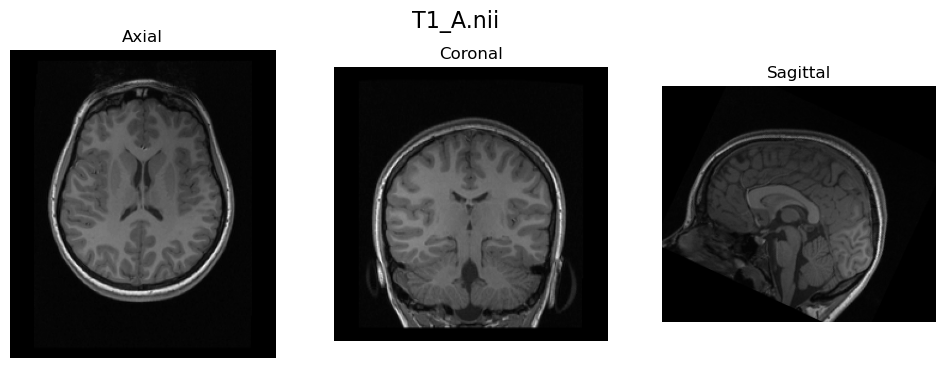

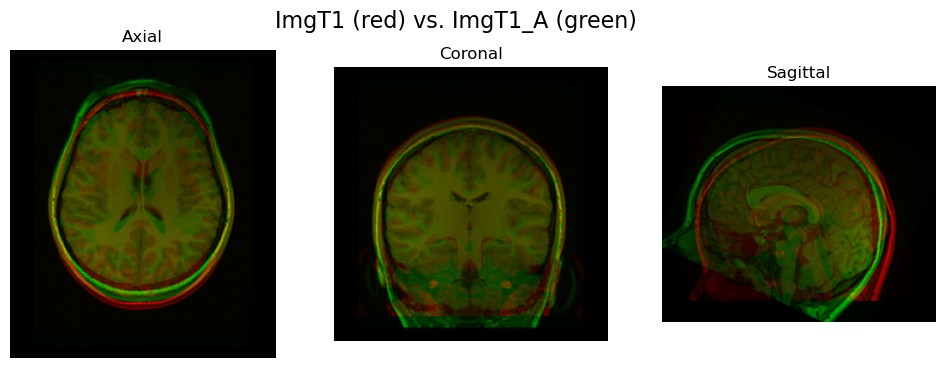

In [15]:
imshow_orthogonal_view(ImgT1_A, title='T1_A.nii')
overlay_slices(vol_sitk, ImgT1_A, title = 'ImgT1 (red) vs. ImgT1_A (green)')

### Exercise 5
Find the geometrical transformation of the moving image to the fixed image. The moving image is ImgT1_A.nii and the fixed image is ImgT1.nii. The new rotated image is named ImgT1_B.nii and the optimal affine transformation matrix text file is named A1.txt.

In [17]:
fixed_image = vol_sitk # ImgT1.nii
moving_image = ImgT1_A # ImgT1_A.nii

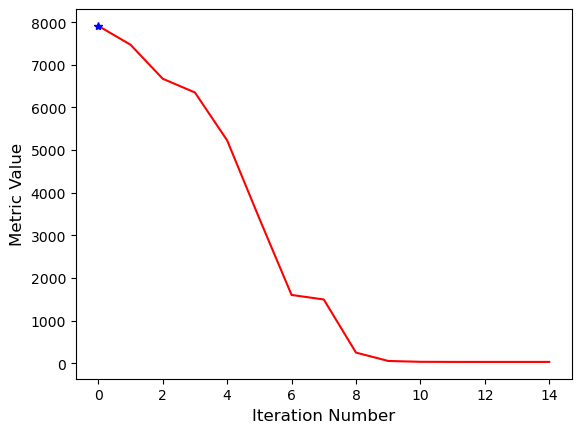

In [18]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')

### Exercise 6
Show the ortho-view of the ImgT1_B.nii. Display the optimal affine matrix found. Does it agree with the expected and what is expected? Why?

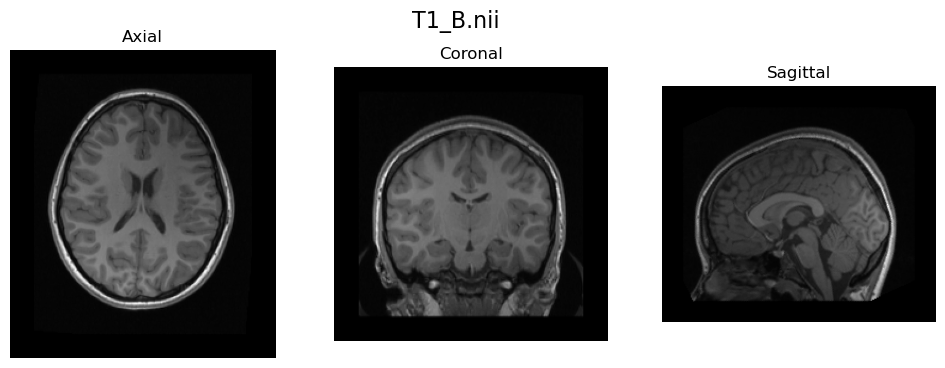

In [19]:
imshow_orthogonal_view(ImgT1_B, title='T1_B.nii')


In [20]:
estimated_tform = tform_reg.GetNthTransform(0).GetMatrix() # Transform matrix
estimated_translation = tform_reg.GetNthTransform(0).GetTranslation() # Translation vector
params = tform_reg.GetParameters() # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)

In [21]:
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""
    matrix = np.zeros((4, 4))
    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))
    matrix[:3, 3] = transform.GetTranslation()
    matrix[3, 3] = 1
    return matrix

matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

In [22]:
tform_reg.WriteTransform(dir_in + 'A1.tfm')
tform_loaded = sitk.ReadTransform(dir_in + 'A1.tfm')

### Exercise 7
By default, SimpleITK uses the fixed image’s origin as the rotation center. Change the rotation center to the center of the fixed image and repeat the registration. Compare the results.

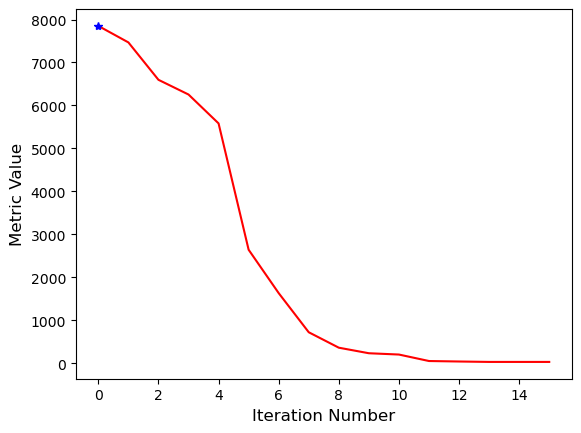

In [24]:
initTransform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')

### Exercise 8
Make four rotation matrices that rotate the ImgT1nii in steps of 60 degrees starting from 60 degrees. Apply the rotation to ImgT1.nii, reslice and store the resulting images as ImgT1_60.nii, ImgT1_120.nii etc. Show in ortho-view that the rotations are applied as expected for each new image.

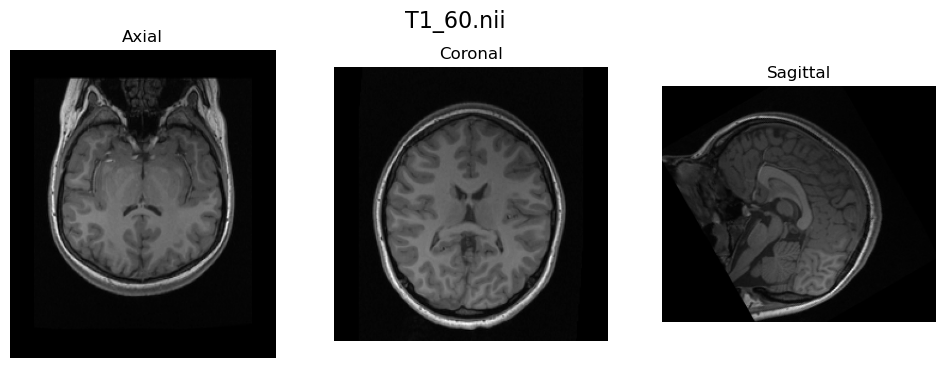

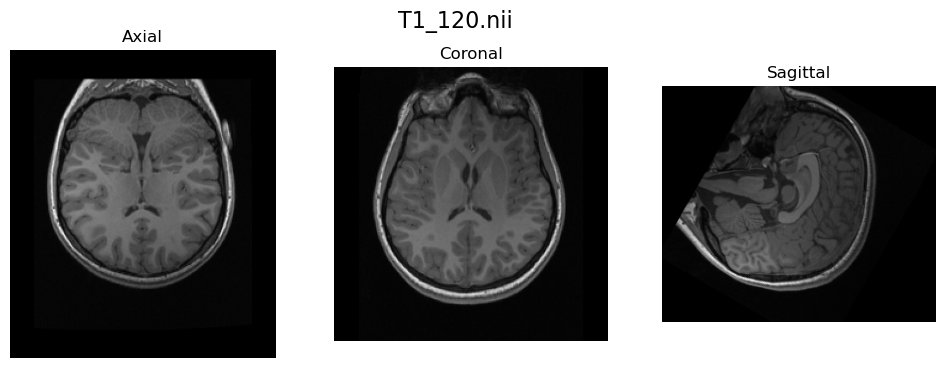

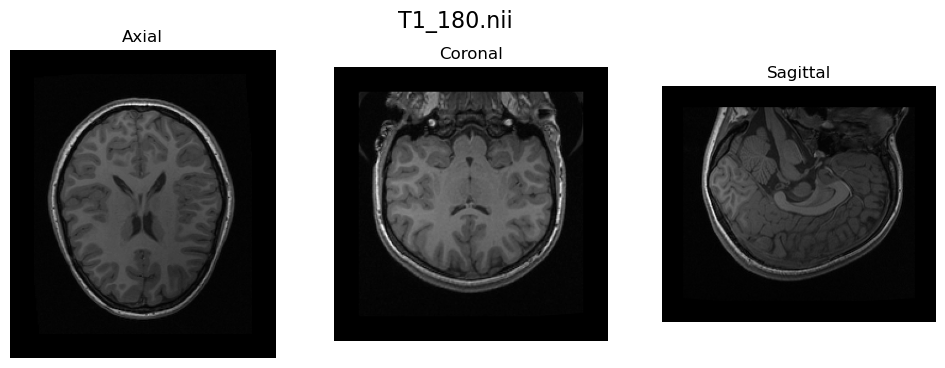

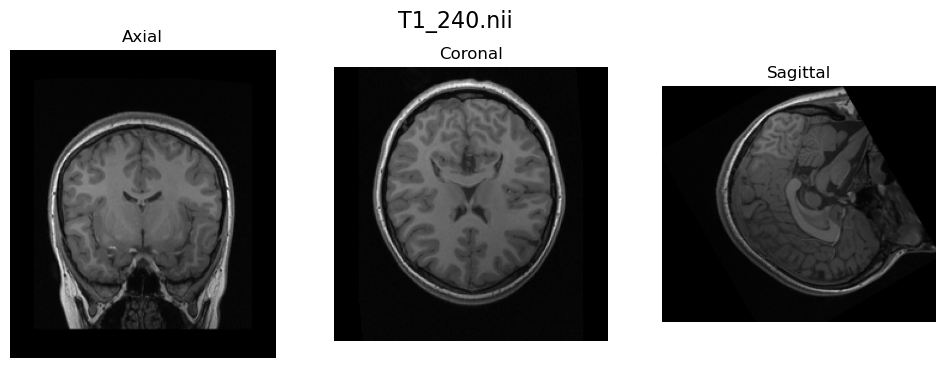

In [28]:
for angle in range(60, 241, 60):
    # Define the roll rotation in radians
    pitch_radians = np.deg2rad(angle)

    # Create the Affine transform and set the rotation
    transform = sitk.AffineTransform(3)

    centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
    centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
    rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

    transform.SetCenter(centre_world) # Set the rotation centre
    transform.SetMatrix(rot_matrix.T.flatten())

    # Apply the transformation to the image
    ImgT1_angle = sitk.Resample(vol_sitk, transform)
    imshow_orthogonal_view(ImgT1_angle, title=f'T1_{angle}.nii')

    # Save the rotated image
    sitk.WriteImage(ImgT1_angle, dir_in + 'ImgT1_' + str(angle) + '.nii')

### Exercise 9
Use ImgT1_120.nii as the fixed image, and the other three rotated images from Exercise 8 as the moving images. Run the registration to find the affine matrix and include the reslicing procedure for each of the moving images. Show in ortho-view the resliced images and describe what the rotation angles are. Save the transforms with the name "Ex9_60.tfm, Ex10_180.tfm, Ex10_240.tfm"


In [30]:
ImgT1_60 = sitk.ReadImage(dir_in + 'ImgT1_60.nii')
ImgT1_120 = sitk.ReadImage(dir_in + 'ImgT1_120.nii')
ImgT1_180 = sitk.ReadImage(dir_in + 'ImgT1_180.nii')
ImgT1_240 = sitk.ReadImage(dir_in + 'ImgT1_240.nii')

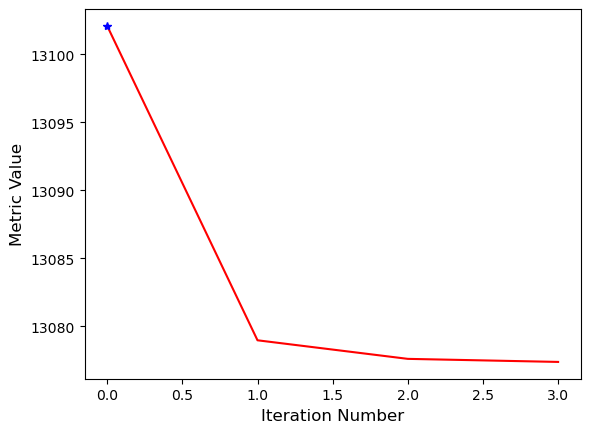

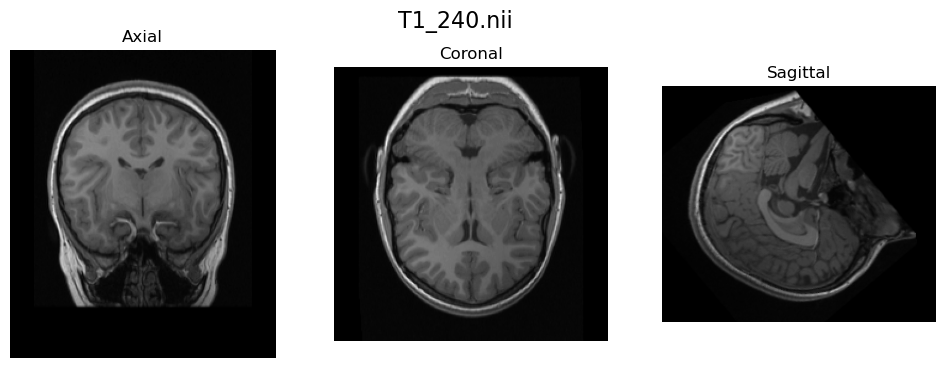

In [31]:
fixed_image = ImgT1_120

for angle in [60, 180, 240]:
    moving_image = globals()['ImgT1_' + str(angle)]
    # Set the registration - Fig. 1 from the Theory Note
    R = sitk.ImageRegistrationMethod()

    # Set a one-level the pyramid scheule. [Pyramid step]
    R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
    R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
    R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set the interpolator [Interpolation step]
    R.SetInterpolator(sitk.sitkLinear)

    # Set the similarity metric [Metric step]
    R.SetMetricAsMeanSquares()

    # Set the sampling strategy [Sampling step]
    R.SetMetricSamplingStrategy(R.RANDOM)
    R.SetMetricSamplingPercentage(0.50)

    # Set the optimizer [Optimization step]
    R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

    # Initialize the transformation type to rigid 
    initTransform = sitk.Euler3DTransform()
    R.SetInitialTransform(initTransform, inPlace=False)

    # Some extra functions to keep track to the optimization process 
    # R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
    R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
    R.AddCommand(sitk.sitkEndEvent, end_plot)
    R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

    # Estimate the registration transformation [metric, optimizer, transform]
    tform_reg = R.Execute(fixed_image, moving_image)

    # Apply the estimated transformation to the moving image
    ImgT1_angle = sitk.Resample(moving_image, tform_reg)
    imshow_orthogonal_view(ImgT1_angle, title=f'T1_{angle}.nii')

    # Save the transform
    tform_reg.WriteTransform(dir_in + 'Ex9_' + str(angle) + '.tfm')

### Exercise 10
Use the ImgT1_240.nii as the fixed image and use the ImgT1.nii as the moving image. Make an affine matrix clockwise by combining the estimated transformation and the affine matrix obtained at each rotation step in exercise 10 and apply reslicing. Show in ortho views that the ImgT1.nii after applying the combined affine matrix is registered as expected. Show the combined affine matrix and explains if it applies the expected rotation angle.



In [ ]:
# Load the transforms from file
tform_60 = ...
tform_180 = ...
tform_240 = ...
tform_0 = ...

# Option A: Combine the transforms using the sitk.CompositeTransform(3) function
# Concatenate - The last added transform is applied first
tform_composite = sitk.CompositeTransform(3)

tform_composite.AddTransform(tform_240.GetNthTransform(0)) 
tform_composite.AddTransform(tform_180.GetNthTransform(0))
tform_composite.AddTransform(tform_60.GetNthTransform(0))
tform_composite.AddTransform(tform_0.GetNthTransform(0))
# Transform the composite transform to an affine transform
affine_composite = composite2affine(tform_composite, centre_world)

# Option B: Combine the transforms manually through multiplication of the homogeneous matrices
A = np.eye(4)
for i in range(tform_composite.GetNumberOfTransforms()-1,-1,-1):
    tform = tform_composite.GetNthTransform(i)
    A_curr = homogeneous_matrix_from_transform(tform)
    A = np.dot(A_curr, A)

tform = sitk.Euler3DTransform()
tform.SetMatrix(A[:3,:3].flatten())
tform.SetTranslation(A[:3,3])
tform.SetCenter(centre_world)